### Load Libraries and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize


df = pd.read_csv('DS_assignment_data.csv')

df.head()

### Data Cleaning - Feature Engineering - Preprocessing

In [99]:
from scipy.stats.mstats import winsorize

def preprocess_data(df):
    # Convert date columns to datetime
    df['DATE_OF_BIRTH'] = pd.to_datetime(df['DATE_OF_BIRTH'], format='%d-%m-%y', errors='coerce')
    df['DISBURSAL_DATE'] = pd.to_datetime(df['DISBURSAL_DATE'], format='%d-%m-%y', errors='coerce')

    # Calculate age at disbursal in years
    df['AGE'] = (df['DISBURSAL_DATE'] - df['DATE_OF_BIRTH']).dt.days / 365.25

    # Function to convert age strings like "3yrs 4mon" to months
    def convert_age_to_months(age_str):
        if pd.isna(age_str) or age_str == '0yrs 0mon':
            return 0
        years = int(age_str.split('yrs')[0].strip())
        months = int(age_str.split(' ')[1].replace('mon', '').strip())
        return years * 12 + months

    # Apply conversion on relevant columns
    df['AVERAGE_ACCT_AGE_MONTHS'] = df['AVERAGE_ACCT_AGE'].apply(convert_age_to_months)
    df['CREDIT_HISTORY_LENGTH_MONTHS'] = df['CREDIT_HISTORY_LENGTH'].apply(convert_age_to_months)

    # Handle employment type: fill missing and blank with 'Unknown'
    df['EMPLOYMENT_TYPE'] = df['EMPLOYMENT_TYPE'].fillna('Unknown').replace('', 'Unknown')

    # Create dummy variables for employment type, drop first to avoid multicollinearity
    employment_dummies = pd.get_dummies(df['EMPLOYMENT_TYPE'], prefix='EMP', drop_first=True)
    df = pd.concat([df, employment_dummies], axis=1)

    # Handle missing PERFORM_CNS_SCORE values (assuming 0 = missing)
    df['PERFORM_CNS_SCORE'] = df['PERFORM_CNS_SCORE'].replace(0, np.nan)
    df['PERFORM_CNS_SCORE'] = df['PERFORM_CNS_SCORE'].fillna(df['PERFORM_CNS_SCORE'].median())

    
    # Define columns for modeling
    model_vars = [
        'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 
        'EMP_Self employed', 'PERFORM_CNS_SCORE',
        'PRI_NO_OF_ACCTS', 'PRI_CURRENT_BALANCE',
        'PRIMARY_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
        'AVERAGE_ACCT_AGE_MONTHS', 'NO_OF_INQUIRIES'
    ]

    model_df = df[model_vars].copy()

    # Check missing values before treatment
    print("Missing values before treatment:")
    print(model_df.isnull().sum())

    # Fill missing continuous vars with median
    for col in ['PRI_CURRENT_BALANCE', 'PRIMARY_INSTAL_AMT']:
        model_df[col] = model_df[col].fillna(model_df[col].median())

    # Fill missing count vars with 0
    for col in ['PRI_NO_OF_ACCTS', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES']:
        model_df[col] = model_df[col].fillna(0)

    print("\nMissing values after treatment:")
    print(model_df.isnull().sum())

    # Remove rows where ASSET_COST is 0 (invalid)
    zero_asset_cost_count = (model_df['ASSET_COST'] == 0).sum()
    print(f"\nNumber of rows with ASSET_COST == 0: {zero_asset_cost_count}")
    model_df = model_df[model_df['ASSET_COST'] > 0]

    return model_df


### OLS Analysis

In [92]:
df_model = preprocess_data(df)
# Define X and y
X = df_model.drop(columns='DISBURSED_AMOUNT')
y = df_model['DISBURSED_AMOUNT']

# Add intercept
X = sm.add_constant(X)

# Convert all columns to numeric and cast bools to int
X = X.apply(pd.to_numeric, errors='coerce')
X = X.astype({col: 'int' for col in X.select_dtypes(include='bool').columns})
y = pd.to_numeric(y, errors='coerce')

# Drop rows with missing values in either X or y
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop(columns='DISBURSED_AMOUNT')
y = combined['DISBURSED_AMOUNT']

# Fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())


Missing values before treatment:
DISBURSED_AMOUNT                0
ASSET_COST                      0
LTV                             0
EMP_Self employed               0
PERFORM_CNS_SCORE               0
PRI_NO_OF_ACCTS                 0
PRI_CURRENT_BALANCE             0
PRIMARY_INSTAL_AMT              0
NEW_ACCTS_IN_LAST_SIX_MONTHS    0
AVERAGE_ACCT_AGE_MONTHS         0
NO_OF_INQUIRIES                 0
dtype: int64

Missing values after treatment:
DISBURSED_AMOUNT                0
ASSET_COST                      0
LTV                             0
EMP_Self employed               0
PERFORM_CNS_SCORE               0
PRI_NO_OF_ACCTS                 0
PRI_CURRENT_BALANCE             0
PRIMARY_INSTAL_AMT              0
NEW_ACCTS_IN_LAST_SIX_MONTHS    0
AVERAGE_ACCT_AGE_MONTHS         0
NO_OF_INQUIRIES                 0
dtype: int64

Number of rows with ASSET_COST == 0: 0
                            OLS Regression Results                            
Dep. Variable:       DISBURSED_AMOUNT   R

### Assumption Check 1: No problematic outliers using Cook’s Distance

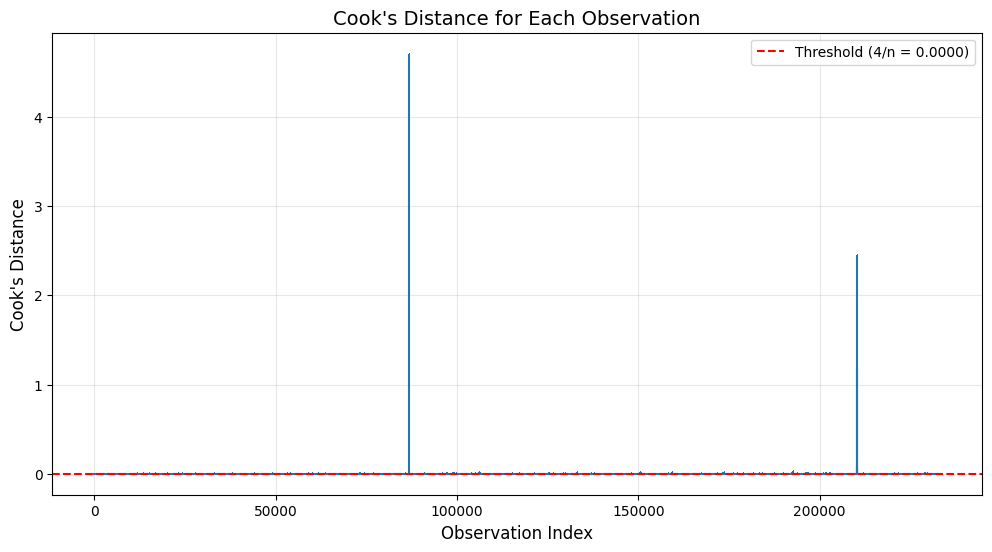


Number of influential points (Cook's D > 4/n): 8945
Indices of influential points: [    13     72     90 ... 232884 232934 233118]

Influential Observations (Processed Data - Modeling Variables):


,DISBURSED_AMOUNT,ASSET_COST,LTV,EMP_Self employed,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_CURRENT_BALANCE,PRIMARY_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE_MONTHS,NO_OF_INQUIRIES
UNIQUEID,,,,,,,,,,,
479533,49478,57010,89.46,False,738.0,10,79750,23309,1,12,4
573625,54273,71840,80.73,False,18.0,1,0,0,0,154,0
639321,51428,64840,84.82,False,679.0,0,0,0,0,0,4
437939,27229,61865,44.77,False,667.0,4,4340,0,1,6,0
450504,54303,61865,88.90,True,671.0,11,684483,7230,9,4,0
...,...,...,...,...,...,...,...,...,...,...,...
649871,101060,122800,83.88,False,437.0,2,10588,0,1,1,2
628056,57761,106350,55.33,True,726.0,25,900,7873,0,4,4
627440,75779,102900,74.83,True,763.0,4,59450,4921,2,12,11



Comparison - Mean Values (Influential vs. Full Dataset):


,Full Dataset,Influential Points
DISBURSED_AMOUNT,54356.993528,66077.888429
ASSET_COST,75865.068144,111897.838457
LTV,74.746530,62.567814
EMP_Self employed,0.547428,0.582225
PERFORM_CNS_SCORE,630.049259,575.762996
PRI_NO_OF_ACCTS,2.440636,6.205143
PRI_CURRENT_BALANCE,165900.076936,763450.790721
PRIMARY_INSTAL_AMT,13105.481720,82445.257909
NEW_ACCTS_IN_LAST_SIX_MONTHS,0.381833,0.955953
AVERAGE_ACCT_AGE_MONTHS,8.915764,15.183790


In [93]:
# Calculate Cook's Distance
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]  # Cook's D values
n = len(cooks_d)  # Number of observations
threshold = 4 / n  # Common threshold

# --- Plot Cook's Distance ---
plt.figure(figsize=(12, 6))
plt.stem(np.arange(n), cooks_d, markerfmt=",", linefmt="C0-", basefmt="C0-")
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold (4/n = {threshold:.4f})')
plt.title("Cook's Distance for Each Observation", fontsize=14)
plt.xlabel('Observation Index', fontsize=12)
plt.ylabel("Cook's Distance", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# --- Identify Influential Points ---
influential_points = np.where(cooks_d > threshold)[0]
print(f'\nNumber of influential points (Cook\'s D > 4/n): {len(influential_points)}')
print(f'Indices of influential points: {influential_points}')

# --- Inspect Influential Rows (PROCESSED DATA) ---
try:
    print("\nInfluential Observations (Processed Data - Modeling Variables):")
    display(df_model.iloc[influential_points])  # Nicer formatting than print()
    
    # Summary stats for comparison
    print("\nComparison - Mean Values (Influential vs. Full Dataset):")
    comparison_df = pd.DataFrame({
        'Full Dataset': df_model.mean(),
        'Influential Points': df_model.iloc[influential_points].mean()
    })
    display(comparison_df)
    
except NameError:
    print("Processed DataFrame (df_model) not found. Did you run preprocess_data()?")

        
except NameError:
    print("Original DataFrame (df) not found. Ensure it's loaded before preprocessing.")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate Cook's Distance
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
threshold = 4 / len(X)
influential_idx = np.where(cooks_d > threshold)[0]

# Step 2: Flag influential points in dataset
df_model['is_influential'] = False
df_model.loc[df_model.index[influential_idx], 'is_influential'] = True

# Step 3: Compare descriptive stats
summary = df_model.groupby('is_influential').describe().transpose()
print(summary)

# Step 4: Optional visual inspection
cols_to_plot = ['ASSET_COST', 'LTV', 'PERFORM_CNS_SCORE', 'DISBURSED_AMOUNT']
for col in cols_to_plot:
    sns.boxplot(x='is_influential', y=col, data=df_model)
    plt.title(f'{col} — Influential vs. Non-influential')
    plt.show()


### Assumption Check 2: Check Multicollinearity (VIF)

In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Ensure all variables are numeric
X_vif = X.copy()
X_vif = X_vif.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaNs just in case
X_vif = X_vif.dropna()

# Also make sure the dtype is consistent (float64 preferred)
X_vif = X_vif.astype(float)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))


                         feature         VIF
0                          const  101.551662
5                PRI_NO_OF_ACCTS    1.664036
8   NEW_ACCTS_IN_LAST_SIX_MONTHS    1.501527
2                            LTV    1.124077
6            PRI_CURRENT_BALANCE    1.121451
9        AVERAGE_ACCT_AGE_MONTHS    1.118689
1                     ASSET_COST    1.100240
7             PRIMARY_INSTAL_AMT    1.088578
10               NO_OF_INQUIRIES    1.087241
4              PERFORM_CNS_SCORE    1.049841
3              EMP_Self employed    1.011643


### Assumption Check 4: Linearity of relationship

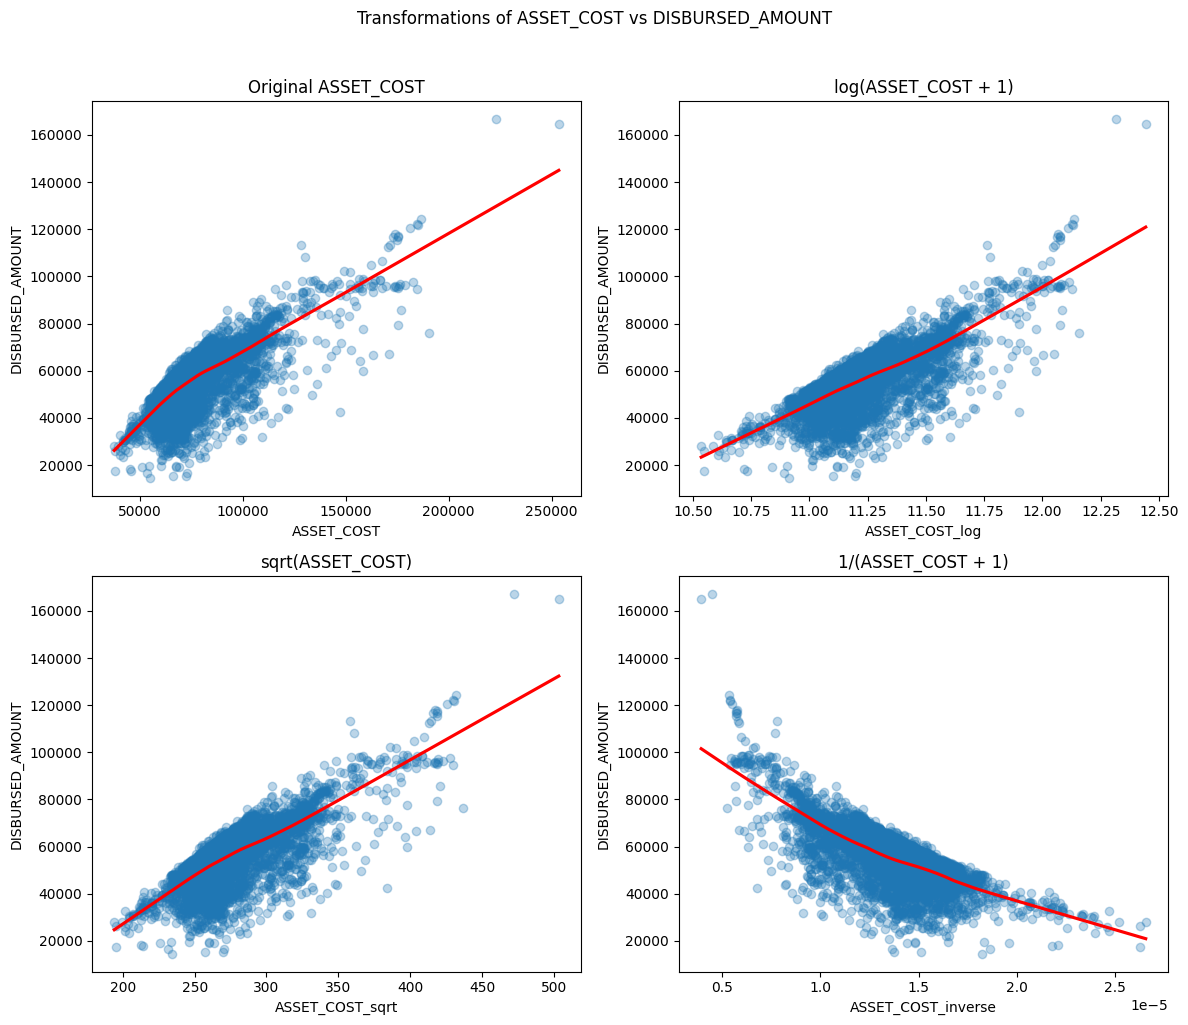

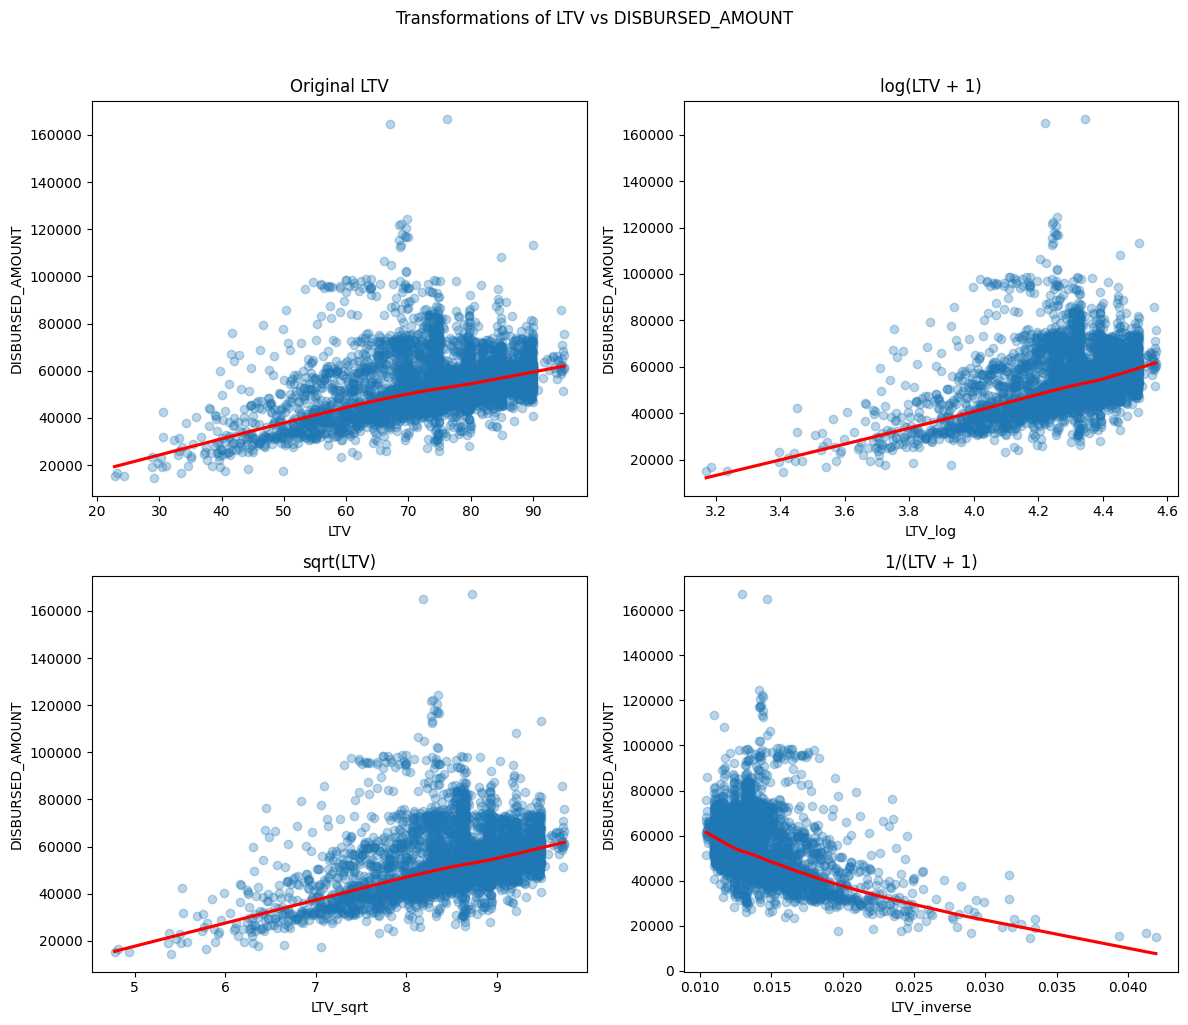

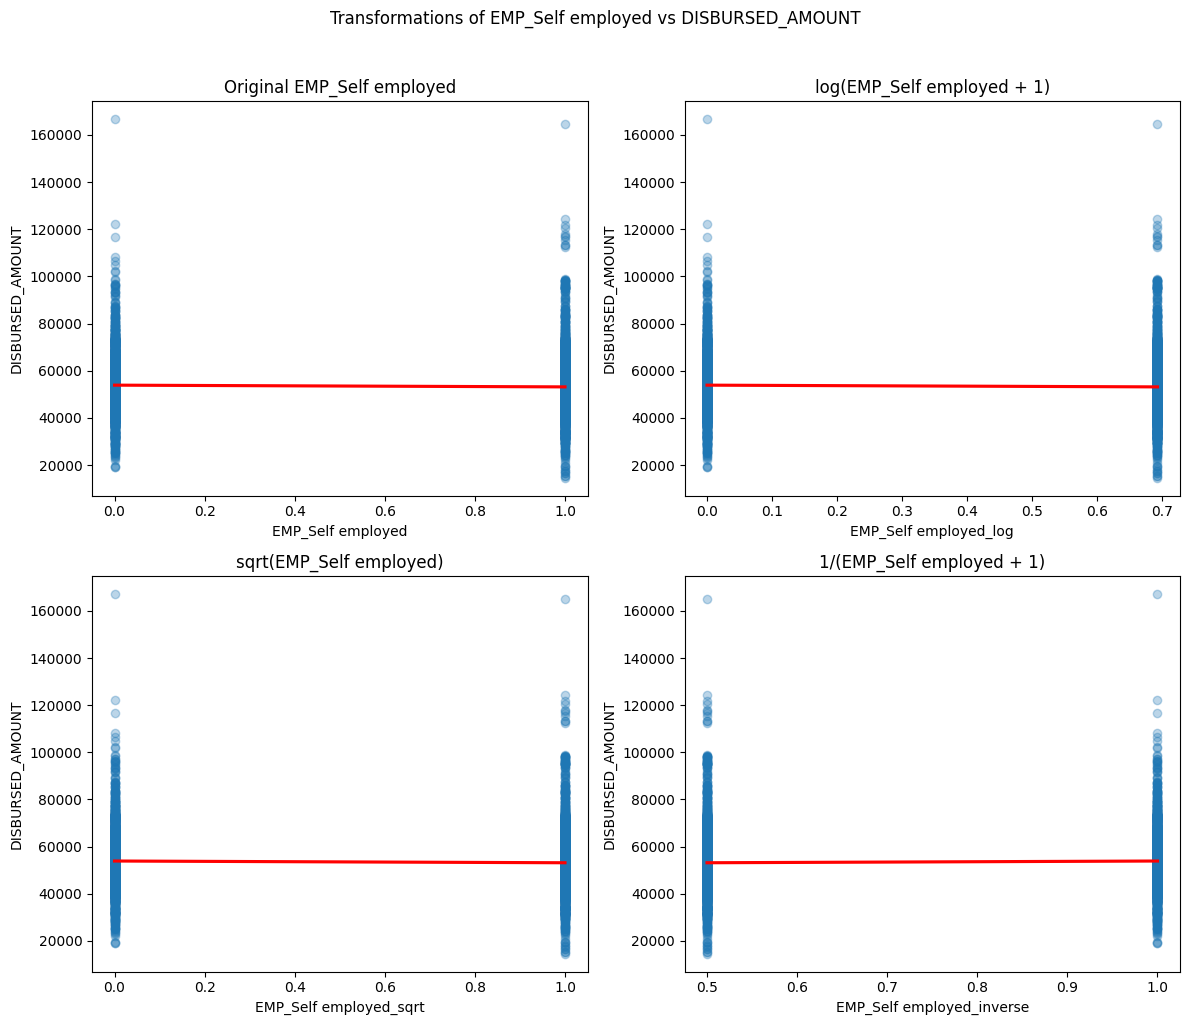

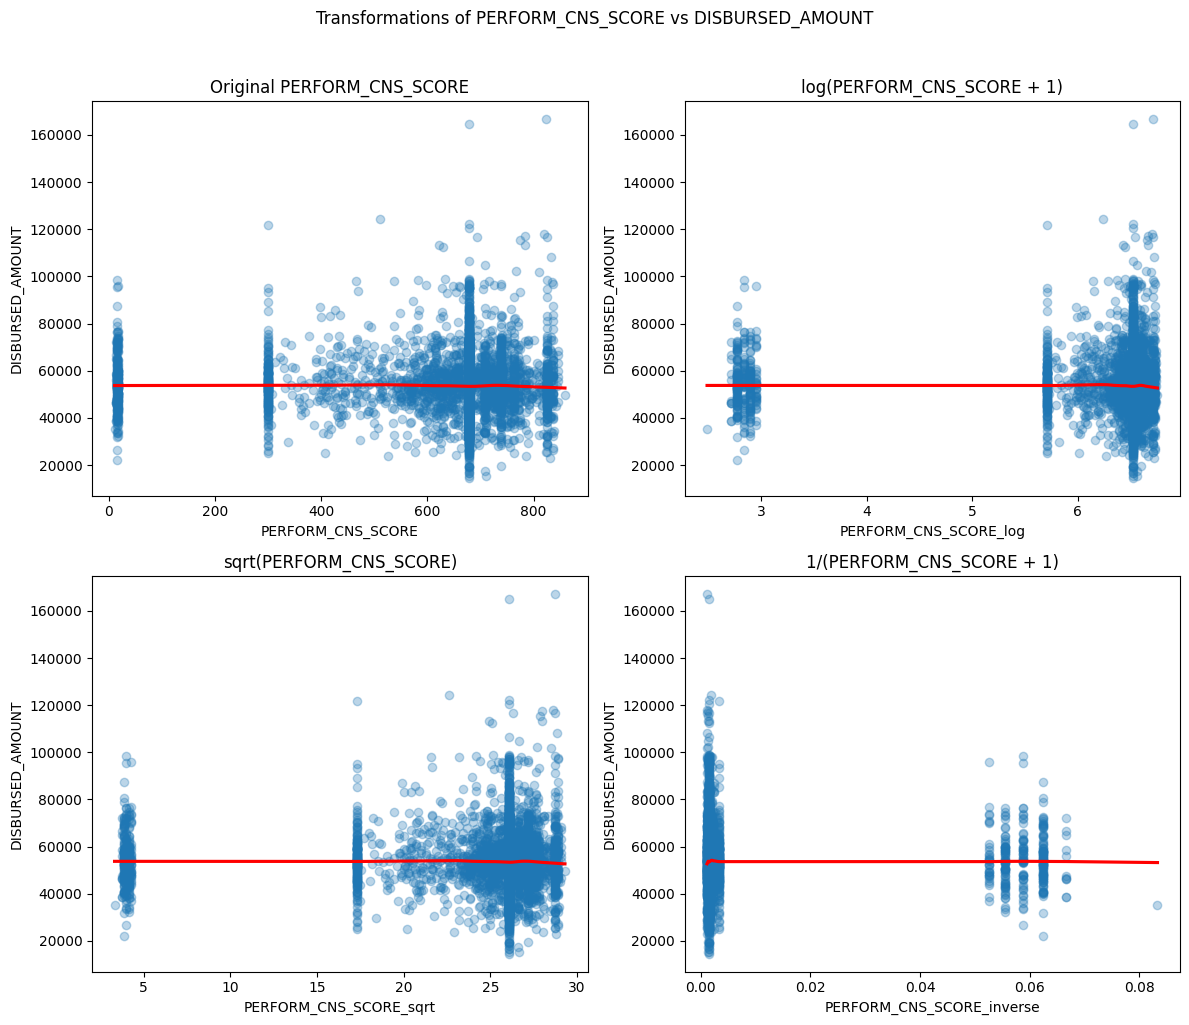

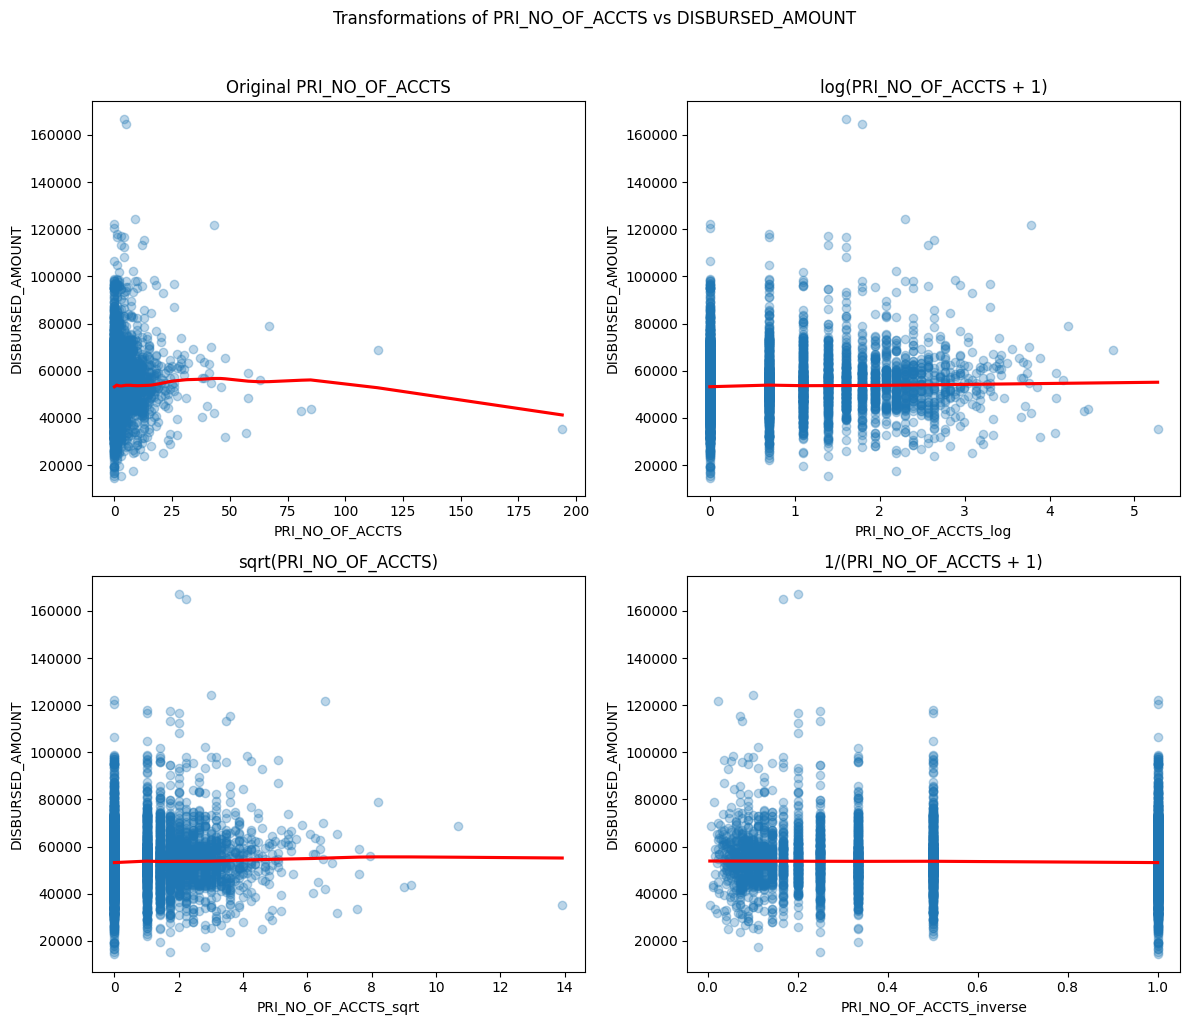

c:\Users\jeffr\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jeffr\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jeffr\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jeffr\miniconda3\Lib\site-packages\numpy\core\function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\jeffr\miniconda3\Lib\site-packages\numpy\core\function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


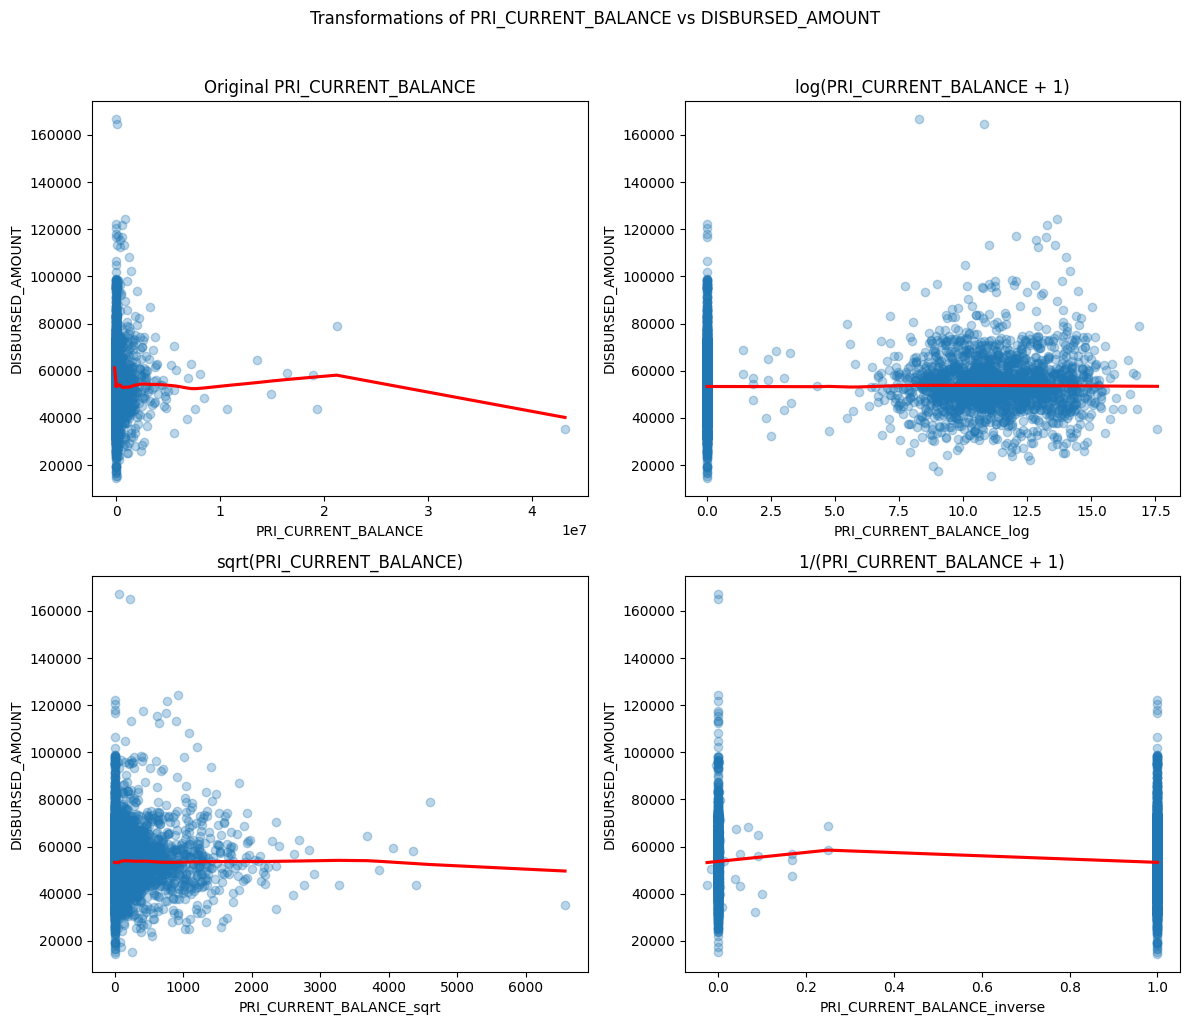

c:\Users\jeffr\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


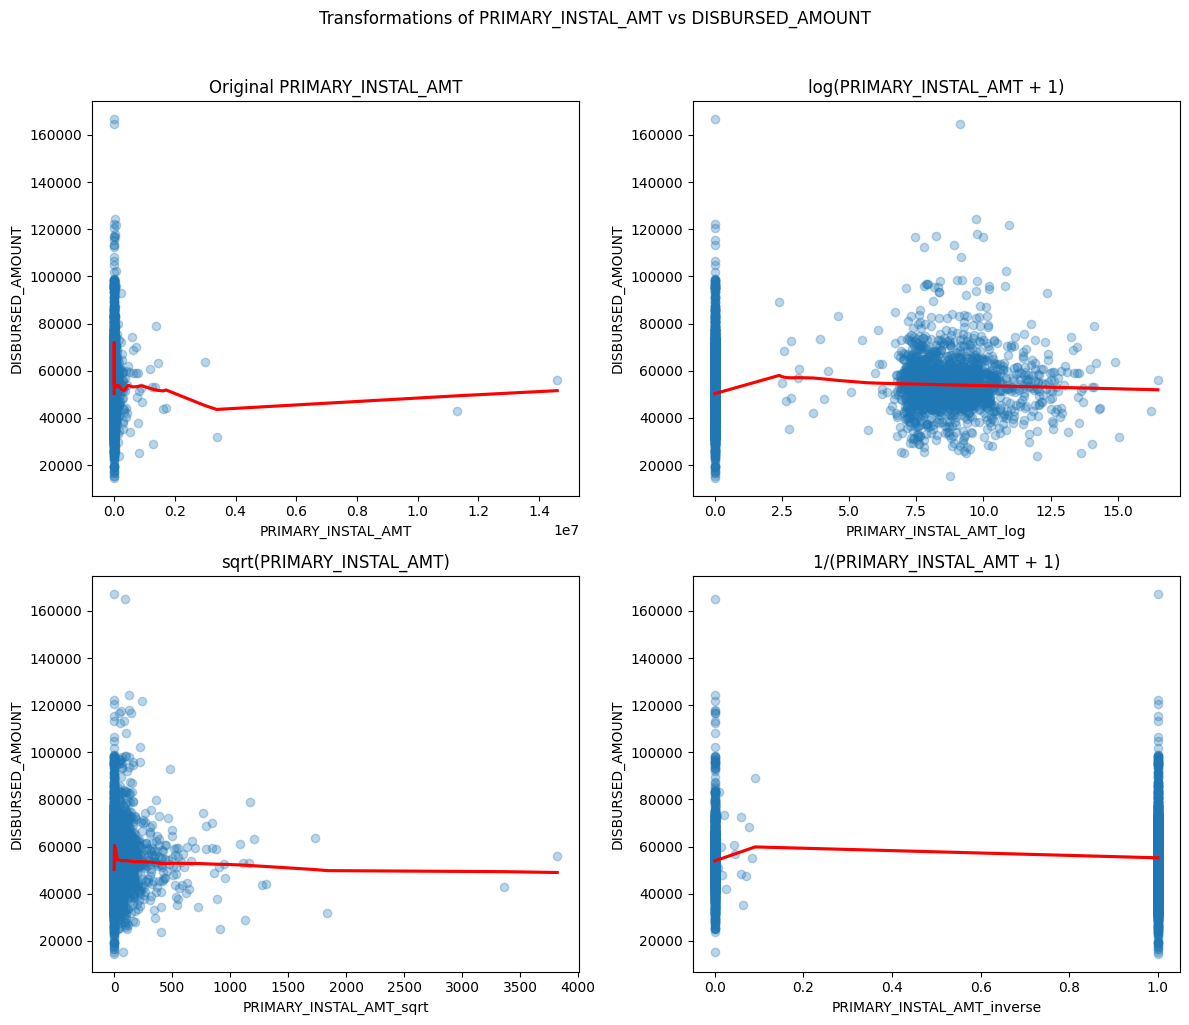

c:\Users\jeffr\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


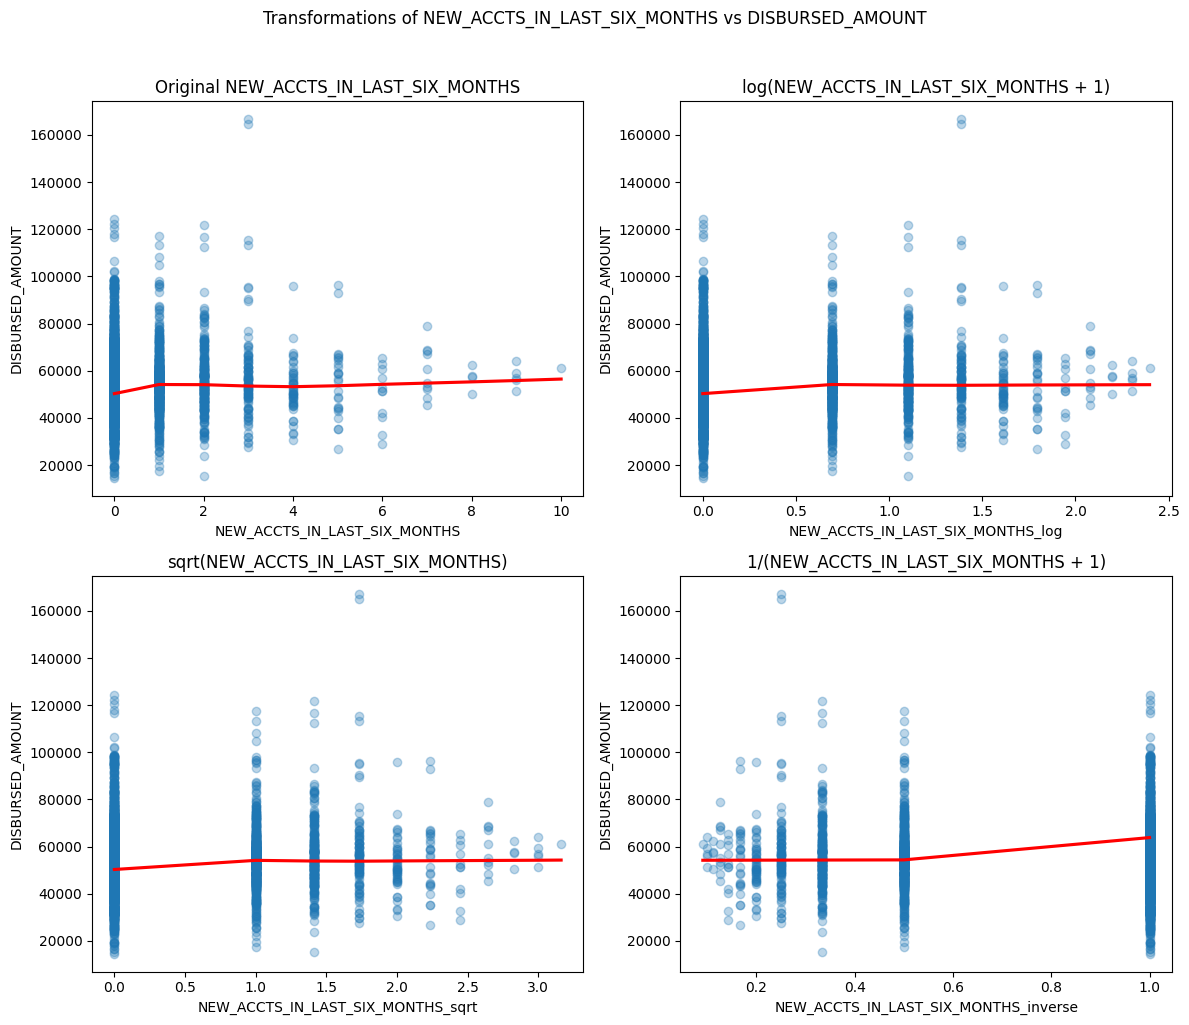

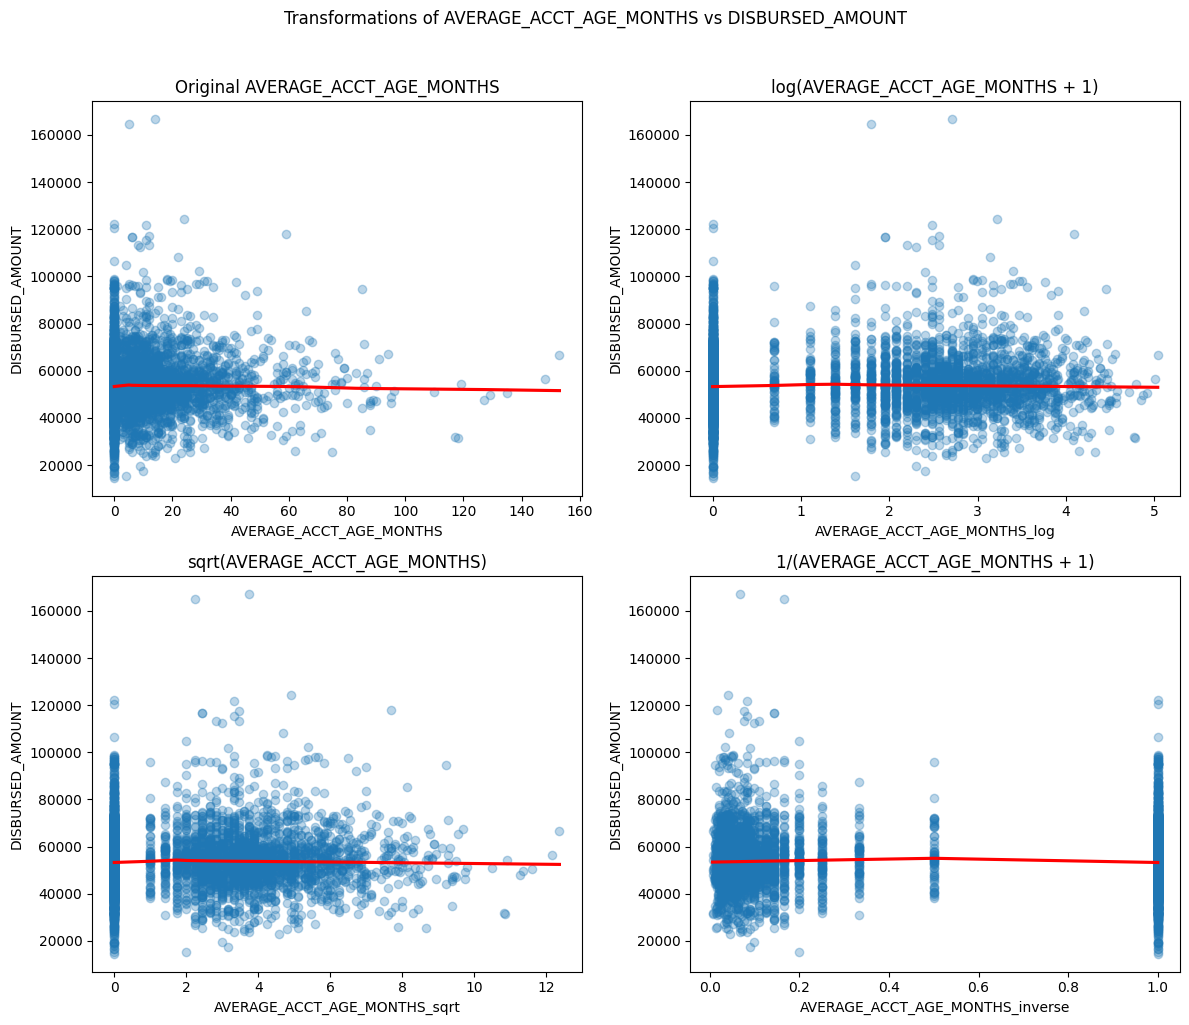

c:\Users\jeffr\miniconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


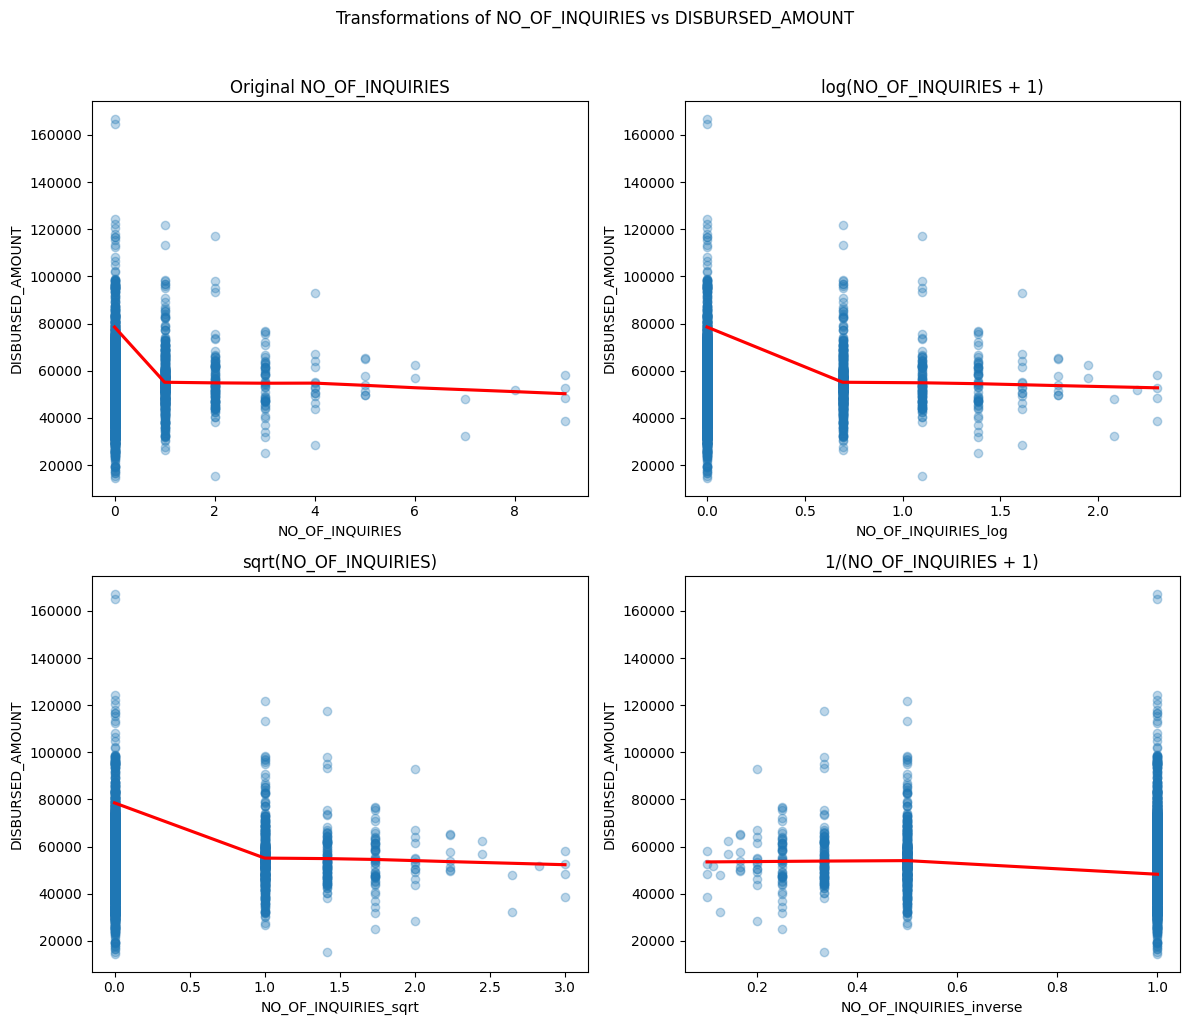

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Combine X and y back for plotting
plot_df = X.copy()
plot_df['DISBURSED_AMOUNT'] = y

# List of features to transform and plot
bad_features = ['ASSET_COST', 'LTV', 
        'EMP_Self employed', 'PERFORM_CNS_SCORE',
        'PRI_NO_OF_ACCTS', 'PRI_CURRENT_BALANCE',
        'PRIMARY_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
        'AVERAGE_ACCT_AGE_MONTHS', 'NO_OF_INQUIRIES'
    
]

# Sample data for performance (optional)
plot_df_sample = plot_df.sample(n=5000, random_state=42)

# Define transformations
def apply_transformations(df, feature):
    df[f'{feature}_log'] = np.log1p(df[feature])          # log(X + 1)
    df[f'{feature}_sqrt'] = np.sqrt(df[feature])          # sqrt(X)
    df[f'{feature}_inverse'] = 1 / (1 + df[feature])      # 1/(X + 1)
    return df

# Plot original and transformed features
for feature in bad_features:
    # Apply transformations
    plot_df_sample = apply_transformations(plot_df_sample, feature)
    
    # Create subplots for original and transformed versions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Transformations of {feature} vs DISBURSED_AMOUNT', y=1.02)
    
    # Original feature
    sns.regplot(
        x=feature,
        y='DISBURSED_AMOUNT',
        data=plot_df_sample,
        lowess=True,
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'},
        ax=axes[0, 0]
    )
    axes[0, 0].set_title(f'Original {feature}')
    
    # Log-transformed
    sns.regplot(
        x=f'{feature}_log',
        y='DISBURSED_AMOUNT',
        data=plot_df_sample,
        lowess=True,
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'},
        ax=axes[0, 1]
    )
    axes[0, 1].set_title(f'log({feature} + 1)')
    
    # Square root-transformed
    sns.regplot(
        x=f'{feature}_sqrt',
        y='DISBURSED_AMOUNT',
        data=plot_df_sample,
        lowess=True,
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'},
        ax=axes[1, 0]
    )
    axes[1, 0].set_title(f'sqrt({feature})')
    
    # Inverse-transformed
    sns.regplot(
        x=f'{feature}_inverse',
        y='DISBURSED_AMOUNT',
        data=plot_df_sample,
        lowess=True,
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'},
        ax=axes[1, 1]
    )
    axes[1, 1].set_title(f'1/({feature} + 1)')
    
    plt.tight_layout()
    plt.show()


### Assumption Check 5: Check heteroskedasticity

In [105]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming you have your fitted OLS model called 'model'

# Get residuals and design matrix (explanatory variables)
residuals = model.resid
exog = model.model.exog  # This is the matrix of regressors including constant

# Run Breusch-Pagan test
bp_test = het_breuschpagan(residuals, exog)

labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

print(dict(zip(labels, bp_test)))


{'Lagrange multiplier statistic': 30997.69544058127, 'p-value': 0.0, 'f-value': 3574.904934997601, 'f p-value': 0.0}


### Assumption Check 6: Normality of residuals

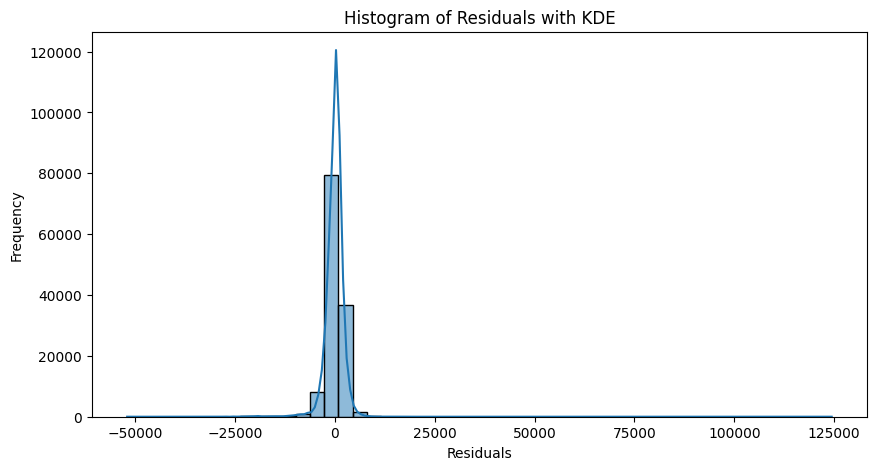

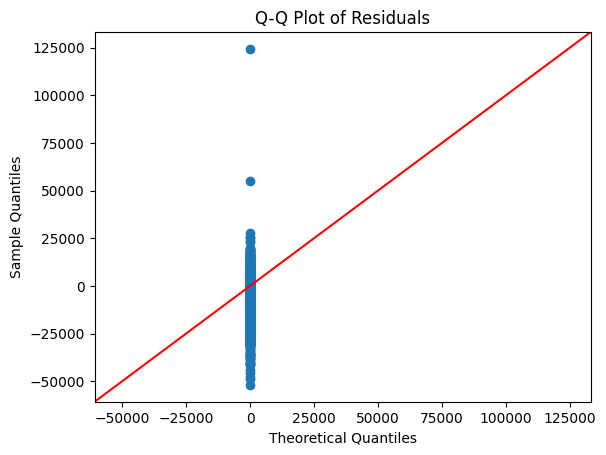

Shapiro-Wilk test statistic: 0.7626, p-value: 0.0000
Residuals do NOT appear normally distributed (reject H0).


In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro

# Assuming you already have your fitted model: 'model'

# Extract residuals
residuals = model.resid

# 1. Histogram with KDE
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Histogram of Residuals with KDE')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# 2. Q-Q Plot
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# 3. Shapiro-Wilk test
stat, p_value = shapiro(residuals.sample(5000, random_state=42))  # sample 5k points for speed
print(f'Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4f}')
if p_value > 0.05:
    print("Residuals appear normally distributed (fail to reject H0).")
else:
    print("Residuals do NOT appear normally distributed (reject H0).")


Final Regression Model

In [98]:
df_model = preprocess_data(df)
# Define X and y
X = df_model.drop(columns='DISBURSED_AMOUNT')
y = df_model['DISBURSED_AMOUNT']

# Add intercept
X = sm.add_constant(X)

# Convert all columns to numeric and cast bools to int
X = X.apply(pd.to_numeric, errors='coerce')
X = X.astype({col: 'int' for col in X.select_dtypes(include='bool').columns})
y = pd.to_numeric(y, errors='coerce')

# Drop rows with missing values in either X or y
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop(columns='DISBURSED_AMOUNT')
y = combined['DISBURSED_AMOUNT']

# Fit OLS model
model2 = sm.OLS(y, X).fit()
results= model2.get_robustcov_results(cov_type='HC3')
print(model.summary())


Missing values before treatment:
DISBURSED_AMOUNT                0
ASSET_COST                      0
LTV                             0
EMP_Self employed               0
PERFORM_CNS_SCORE               0
PRI_NO_OF_ACCTS                 0
PRI_CURRENT_BALANCE             0
PRIMARY_INSTAL_AMT              0
NEW_ACCTS_IN_LAST_SIX_MONTHS    0
AVERAGE_ACCT_AGE_MONTHS         0
NO_OF_INQUIRIES                 0
dtype: int64

Missing values after treatment:
DISBURSED_AMOUNT                0
ASSET_COST                      0
LTV                             0
EMP_Self employed               0
PERFORM_CNS_SCORE               0
PRI_NO_OF_ACCTS                 0
PRI_CURRENT_BALANCE             0
PRIMARY_INSTAL_AMT              0
NEW_ACCTS_IN_LAST_SIX_MONTHS    0
AVERAGE_ACCT_AGE_MONTHS         0
NO_OF_INQUIRIES                 0
dtype: int64

Number of rows with ASSET_COST == 0: 0
                            OLS Regression Results                            
Dep. Variable:       DISBURSED_AMOUNT   R